In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Check if GPU is available
device = 0 if torch.cuda.is_available() else -1

# Define the maximum sequence length
MAX_SEQ_LENGTH = 128

# Function to process a single text file and return sequences with labels for a specific tokenizer
def process_file(file_path, label, tokenizer):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    
    # Tokenize the entire text
    tokens = tokenizer(text, add_special_tokens=False)
    input_ids = tokens['input_ids']

    # Split the input IDs into chunks of MAX_SEQ_LENGTH
    chunks = [input_ids[i:i + MAX_SEQ_LENGTH] for i in range(0, len(input_ids), MAX_SEQ_LENGTH)]

    # Attach label and file name to each sequence
    labeled_sequences = [(chunk, label, file_path) for chunk in chunks]
    
    return labeled_sequences

# Function to process multiple files for a specific category
def process_category(file_paths, label, tokenizer):
    all_sequences = []
    file_sequence_counts = {}
    
    for file_path in file_paths:
        labeled_sequences = process_file(file_path, label, tokenizer)
        file_sequence_counts[file_path] = len(labeled_sequences)
        all_sequences.extend(labeled_sequences)
    
    return all_sequences, file_sequence_counts

# Function to convert sequences into a DataFrame
def sequences_to_dataframe(sequences, tokenizer):
    texts = [tokenizer.decode(seq[0]) for seq in sequences]
    labels = [seq[1] for seq in sequences]
    return pd.DataFrame({'content': texts, 'category': labels})

# Specify file paths for Train, Test, and Valid sets
test_files_0 = ["./data/train/0_The_Hound_of_the_Baskervilles_CD.txt"]
test_files_1 = ["./data/test/1_POIROT_INVESTIGATES.txt"]

valid_files_0 = ["./data/train/0_The_Man_Who_Was_Thursday_GKC.txt"]
valid_files_1 = ["./data/train/1_THE_BIG_FOUR.txt"]

train_files_0 = [
    "./data/train/0_The_Mystery_of_the_Yellow_Room_GL.txt",
    "./data/train/0_The_Middle_Temple_Murder_JF.txt",
    "./data/train/0_JOHN_THORNDYKE'S_CASES_RF.txt",
    "./data/train/0_A_Study_in_Scarlet_CD.txt",
    "./data/train/0_Tremendous_Trifles_GKC.txt",
    "./data/test/0_Caught_in_the_Net_EG.txt",
    "./data/valid/0_The_Red_House_Mystery_AM.txt"
]

train_files_1 = [
    "./data/train/1_The_Secret_of_Chimneys.txt",
    "./data/train/1_The_Mystery_of_the_Blue_Train.txt",
    "./data/train/1_The_Mysterious_Affair_at_Styles.txt",
    "./data/train/1_The_Murder_on_the_Links.txt",
    "./data/train/1_The_Murder_of_Roger_Ackroyd.txt",
    "./data/train/1_THE_MAN_IN_THE_BROWN_SUIT.txt",
    "./data/valid/1_THE_SECRET_ADVERSARY.txt"
]

# Tokenizers for each model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')
xlm_tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

# Prepare data for each model
def prepare_data(tokenizer):
    test_sequences = process_category(test_files_0, label=0, tokenizer=tokenizer)[0] + \
                     process_category(test_files_1, label=1, tokenizer=tokenizer)[0]
    valid_sequences = process_category(valid_files_0, label=0, tokenizer=tokenizer)[0] + \
                      process_category(valid_files_1, label=1, tokenizer=tokenizer)[0]
    train_sequences = process_category(train_files_0, label=0, tokenizer=tokenizer)[0] + \
                      process_category(train_files_1, label=1, tokenizer=tokenizer)[0]

    train_data = sequences_to_dataframe(train_sequences, tokenizer)
    valid_data = sequences_to_dataframe(valid_sequences, tokenizer)
    test_data = sequences_to_dataframe(test_sequences, tokenizer)

    return train_data, valid_data, test_data

# Generate datasets for each model
train_data_bert, valid_data_bert, test_data_bert = prepare_data(bert_tokenizer)
train_data_distilbert, valid_data_distilbert, test_data_distilbert = prepare_data(distilbert_tokenizer)
train_data_xlm, valid_data_xlm, test_data_xlm = prepare_data(xlm_tokenizer)

# Tokenization
def tokenize_texts(texts, tokenizer, max_length=MAX_SEQ_LENGTH):
    return tokenizer(
        list(texts),
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    )

# Tokenize for BERT
bert_train_encodings = tokenize_texts(train_data_bert['content'], bert_tokenizer)
bert_val_encodings = tokenize_texts(valid_data_bert['content'], bert_tokenizer)
bert_test_encodings = tokenize_texts(test_data_bert['content'], bert_tokenizer)

# Tokenize for DistilBERT
distilbert_train_encodings = tokenize_texts(train_data_distilbert['content'], distilbert_tokenizer)
distilbert_val_encodings = tokenize_texts(valid_data_distilbert['content'], distilbert_tokenizer)
distilbert_test_encodings = tokenize_texts(test_data_distilbert['content'], distilbert_tokenizer)

# Tokenize for XLM-RoBERTa
xlm_train_encodings = tokenize_texts(train_data_xlm['content'], xlm_tokenizer)
xlm_val_encodings = tokenize_texts(valid_data_xlm['content'], xlm_tokenizer)
xlm_test_encodings = tokenize_texts(test_data_xlm['content'], xlm_tokenizer)

# Prepare Dataset for PyTorch
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx])
        return item

# Create PyTorch datasets for BERT
bert_train_dataset = CustomDataset(bert_train_encodings, train_data_bert['category'])
bert_val_dataset = CustomDataset(bert_val_encodings, valid_data_bert['category'])
bert_test_dataset = CustomDataset(bert_test_encodings, test_data_bert['category'])

# Create PyTorch datasets for DistilBERT
distilbert_train_dataset = CustomDataset(distilbert_train_encodings, train_data_distilbert['category'])
distilbert_val_dataset = CustomDataset(distilbert_val_encodings, valid_data_distilbert['category'])
distilbert_test_dataset = CustomDataset(distilbert_test_encodings, test_data_distilbert['category'])

# Create PyTorch datasets for XLM-RoBERTa
xlm_train_dataset = CustomDataset(xlm_train_encodings, train_data_xlm['category'])
xlm_val_dataset = CustomDataset(xlm_val_encodings, valid_data_xlm['category'])
xlm_test_dataset = CustomDataset(xlm_test_encodings, test_data_xlm['category'])

# Plot metrics (loss and accuracy)
def plot_metrics(train_losses, eval_losses, eval_accuracies, model_name, fold):
    epochs = range(1, len(eval_losses) + 1)
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, eval_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Loss Per Epoch (Fold {fold + 1})')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, eval_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Validation Accuracy Per Epoch (Fold {fold + 1})')
    plt.legend()

    plt.tight_layout()
    plt.show()

def cross_validate(model_class, model_name_or_path, tokenizer, train_data, num_folds=3, model_name="Model"):
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    texts, labels = train_data['content'], train_data['category']
    fold_metrics = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels)):
        print(f"\nFold {fold + 1}/{num_folds}")

        # Prepare fold datasets
        train_texts, val_texts = texts.iloc[train_idx], texts.iloc[val_idx]
        train_labels, val_labels = labels.iloc[train_idx], labels.iloc[val_idx]
        train_encodings = tokenize_texts(train_texts, tokenizer)
        val_encodings = tokenize_texts(val_texts, tokenizer)
        train_dataset = CustomDataset(train_encodings, train_labels)
        val_dataset = CustomDataset(val_encodings, val_labels)

        # Initialize model
        model = model_class.from_pretrained(model_name_or_path, num_labels=2)

        # TrainingArguments
        training_args = TrainingArguments(
            output_dir=f'./results_{model_name}_fold{fold}',
            evaluation_strategy='epoch',
            save_strategy='epoch',
            logging_strategy='epoch',
            learning_rate=2e-5,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=32,
            num_train_epochs=4,
            weight_decay=0.01,
            logging_dir=f'./logs_{model_name}_fold{fold}',
            load_best_model_at_end=True,
            report_to="none"
        )

        # Metrics
        def compute_metrics(eval_pred):
            logits, labels = eval_pred
            predictions = np.argmax(logits, axis=1)
            precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
            acc = accuracy_score(labels, predictions)
            return {'eval_accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics
        )

        # Train the model
        trainer.train()

        # Extract metrics
        train_log = trainer.state.log_history
        epoch_logs = [log for log in train_log if 'epoch' in log.keys()]
        train_losses = [log['loss'] for log in epoch_logs if 'loss' in log]
        eval_losses = [log['eval_loss'] for log in epoch_logs if 'eval_loss' in log]
        eval_accuracies = [log['eval_accuracy'] for log in epoch_logs if 'eval_accuracy' in log]

        # Plot metrics for this fold
        plot_metrics(train_losses, eval_losses, eval_accuracies, model_name, fold)

        # Evaluate the model on validation set
        eval_results = trainer.evaluate(val_dataset)
        fold_metrics.append(eval_results)
        print(f"Metrics for Fold {fold + 1}: {eval_results}")

    avg_metrics = {key: np.mean([fold[key] for fold in fold_metrics]) for key in fold_metrics[0]}
    print(f"\nAverage Metrics Across {num_folds} Folds: {avg_metrics}")
    return avg_metrics

/home/km/pytorch_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Token indices sequence length is longer than the specified maximum sequence length for this model (74132 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (75689 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (80526 > 512). Running this sequence through the model will result in indexing errors



Fold 1/3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/km/pytorch_env/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.188400,0.090787,0.978236,0.992512,0.964726,0.978421
2,0.036200,0.056358,0.986541,0.991521,0.982083,0.986779
3,0.009500,0.070533,0.987686,0.983898,0.992161,0.988012
4,0.003200,0.068967,0.987400,0.986592,0.988802,0.987696


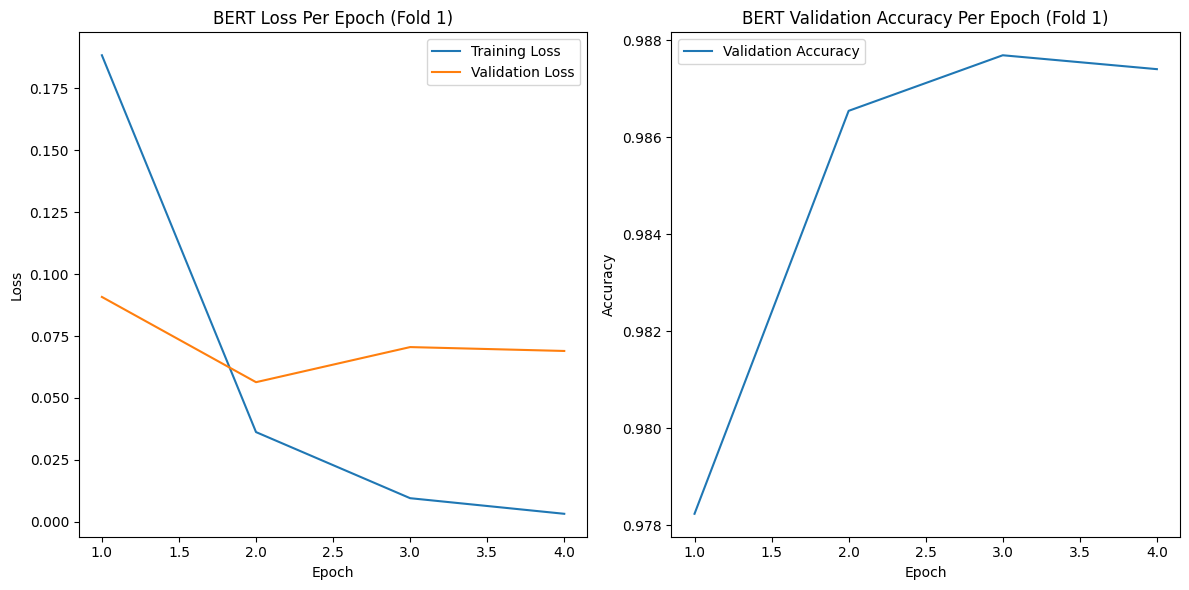

Metrics for Fold 1: {'eval_accuracy': 0.986540664375716, 'eval_loss': 0.05635762959718704, 'eval_precision': 0.9915206331260599, 'eval_recall': 0.9820828667413214, 'eval_f1': 0.9867791842475386, 'eval_runtime': 2.444, 'eval_samples_per_second': 1428.783, 'eval_steps_per_second': 45.007, 'epoch': 4.0}

Fold 2/3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/km/pytorch_env/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.179800,0.058963,0.983677,0.984323,0.983772,0.984047
2,0.035600,0.058184,0.986827,0.981738,0.992725,0.987201
3,0.007000,0.088803,0.983677,0.974232,0.994404,0.984215
4,0.001100,0.072029,0.987113,0.985507,0.989368,0.987434


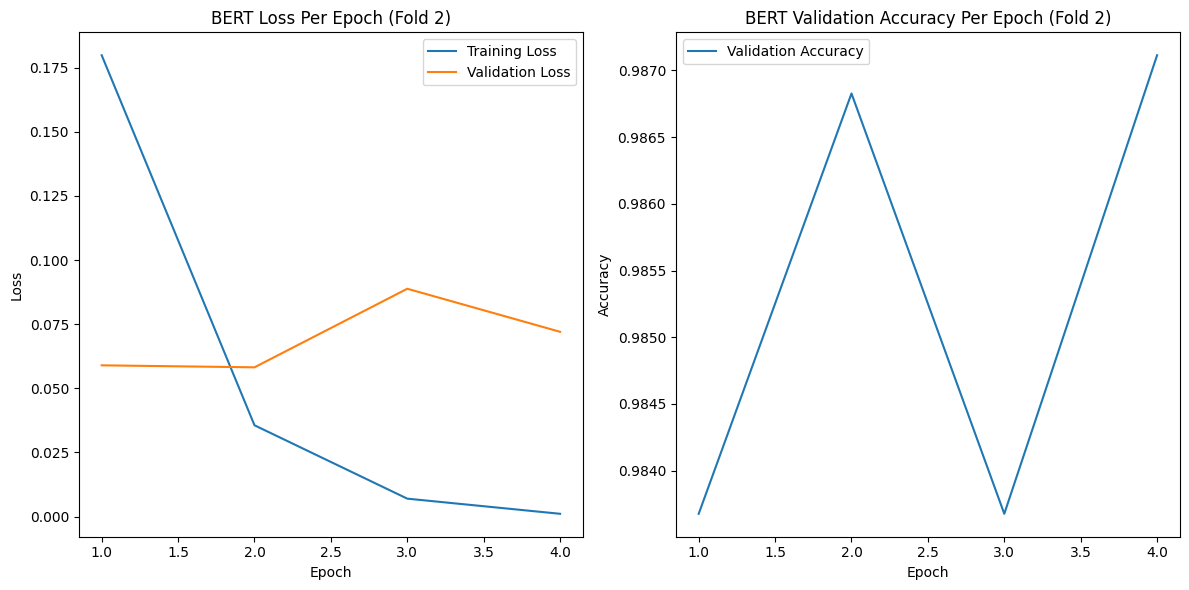

Metrics for Fold 2: {'eval_accuracy': 0.9868270332187858, 'eval_loss': 0.05818360671401024, 'eval_precision': 0.981737686773658, 'eval_recall': 0.9927252378287633, 'eval_f1': 0.9872008903728436, 'eval_runtime': 2.5171, 'eval_samples_per_second': 1387.306, 'eval_steps_per_second': 43.701, 'epoch': 4.0}

Fold 3/3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/km/pytorch_env/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.206200,0.080675,0.974513,0.993605,0.956351,0.974622
2,0.037700,0.063505,0.986254,0.985483,0.987689,0.986585
3,0.014300,0.067508,0.988545,0.991559,0.986010,0.988777
4,0.002900,0.070551,0.988259,0.987165,0.989927,0.988544


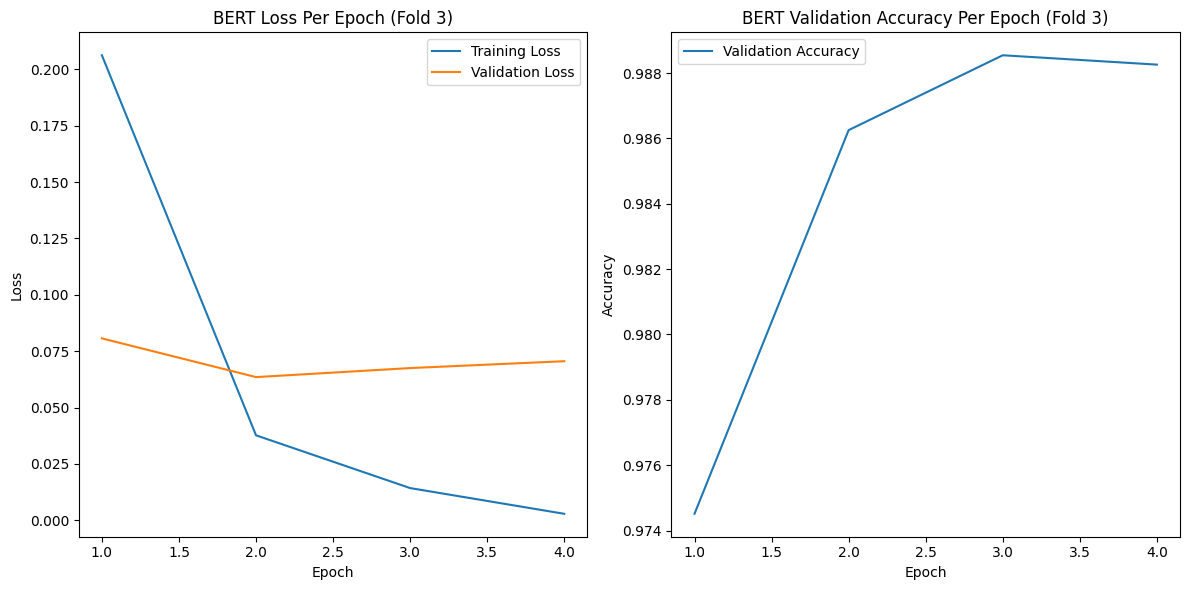

Metrics for Fold 3: {'eval_accuracy': 0.9862542955326461, 'eval_loss': 0.06350501626729965, 'eval_precision': 0.9854829704075935, 'eval_recall': 0.9876888640179071, 'eval_f1': 0.9865846841811068, 'eval_runtime': 2.456, 'eval_samples_per_second': 1421.85, 'eval_steps_per_second': 44.789, 'epoch': 4.0}

Average Metrics Across 3 Folds: {'eval_accuracy': np.float64(0.986540664375716), 'eval_loss': np.float64(0.05934875085949898), 'eval_precision': np.float64(0.9862470967691038), 'eval_recall': np.float64(0.9874989895293306), 'eval_f1': np.float64(0.9868549196004963), 'eval_runtime': np.float64(2.4723666666666664), 'eval_samples_per_second': np.float64(1412.6463333333334), 'eval_steps_per_second': np.float64(44.499), 'epoch': np.float64(4.0)}


In [2]:
# Cross-validate for BERT
avg_metrics_bert = cross_validate(
    model_class=BertForSequenceClassification,
    model_name_or_path='bert-base-uncased',
    tokenizer=bert_tokenizer,
    train_data=train_data_bert,
    num_folds=3,
    model_name="BERT"
)


Fold 1/3


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/km/pytorch_env/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.227200,0.102478,0.969961,0.957356,0.985189,0.971073
2,0.066800,0.058452,0.984559,0.983060,0.986835,0.984944
3,0.021500,0.077585,0.983717,0.992192,0.975864,0.983960
4,0.003500,0.074254,0.985682,0.987885,0.984092,0.985985


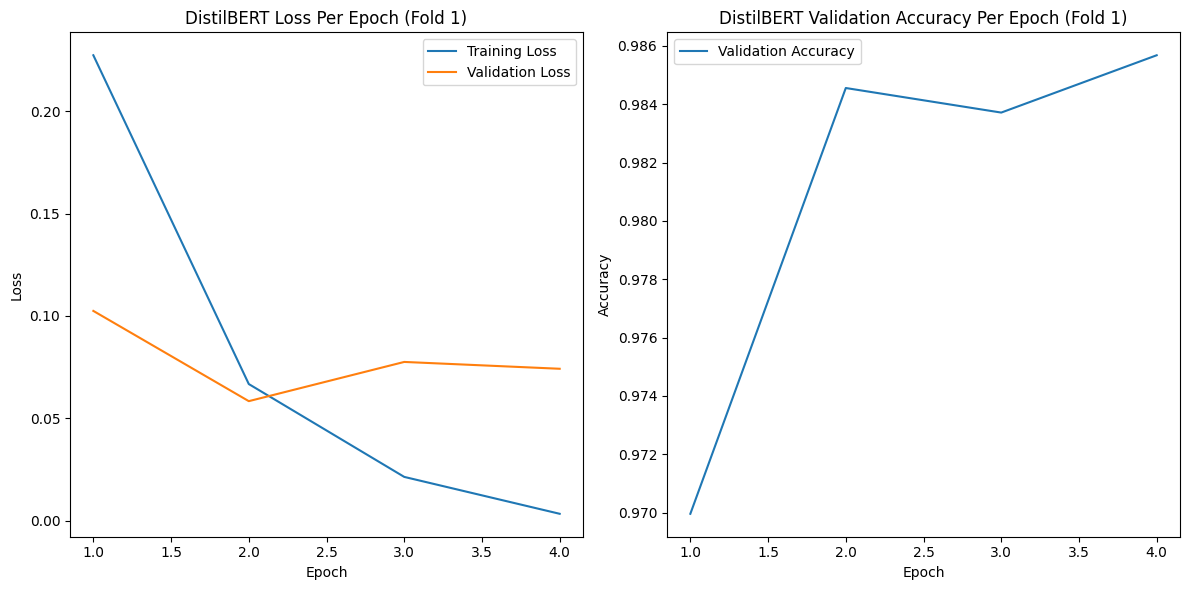

Metrics for Fold 1: {'eval_accuracy': 0.9845592363840538, 'eval_loss': 0.05845220014452934, 'eval_precision': 0.9830601092896175, 'eval_recall': 0.9868348875479978, 'eval_f1': 0.9849438817410348, 'eval_runtime': 1.2867, 'eval_samples_per_second': 2768.288, 'eval_steps_per_second': 87.043, 'epoch': 4.0}

Fold 2/3


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/km/pytorch_env/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.221600,0.114640,0.966592,0.953674,0.982447,0.967847
2,0.054100,0.108063,0.975295,0.965147,0.987383,0.976139
3,0.019100,0.110838,0.977541,0.977011,0.979155,0.978082
4,0.006100,0.111782,0.979225,0.984488,0.974767,0.979603


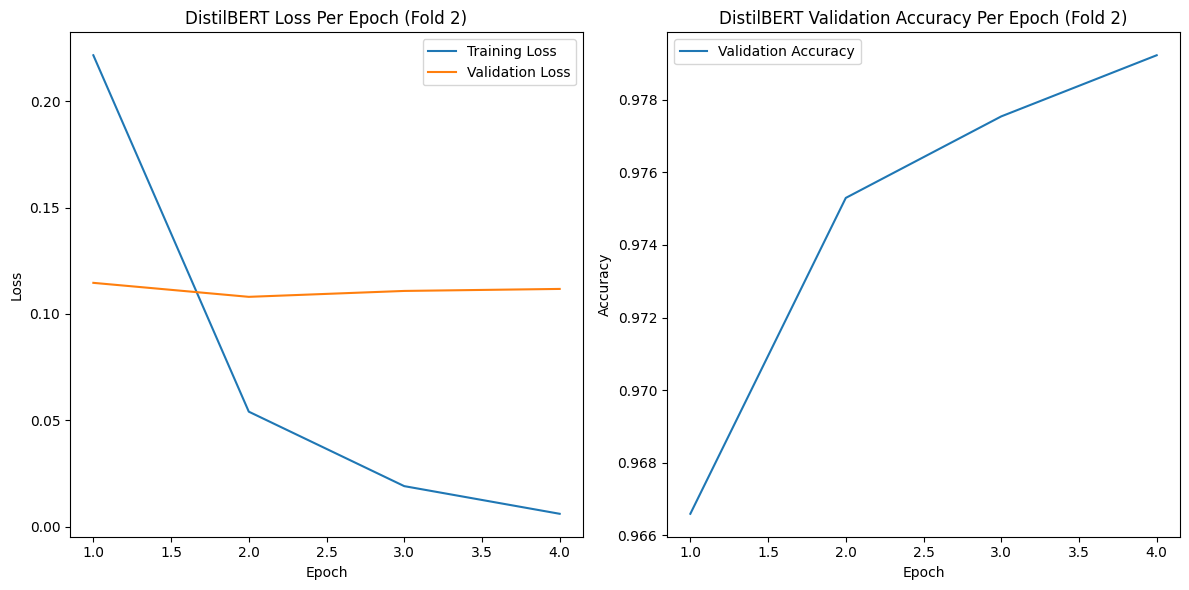

Metrics for Fold 2: {'eval_accuracy': 0.9752947782144863, 'eval_loss': 0.10806319117546082, 'eval_precision': 0.9651474530831099, 'eval_recall': 0.9873834339001646, 'eval_f1': 0.9761388286334056, 'eval_runtime': 1.2812, 'eval_samples_per_second': 2780.207, 'eval_steps_per_second': 87.418, 'epoch': 4.0}

Fold 3/3


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/km/pytorch_env/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.224100,0.078571,0.973610,0.967550,0.981349,0.974401
2,0.057000,0.091588,0.978102,0.979132,0.978058,0.978595
3,0.017700,0.115950,0.977821,0.964819,0.992869,0.978643
4,0.003600,0.098674,0.982313,0.984581,0.980801,0.982688


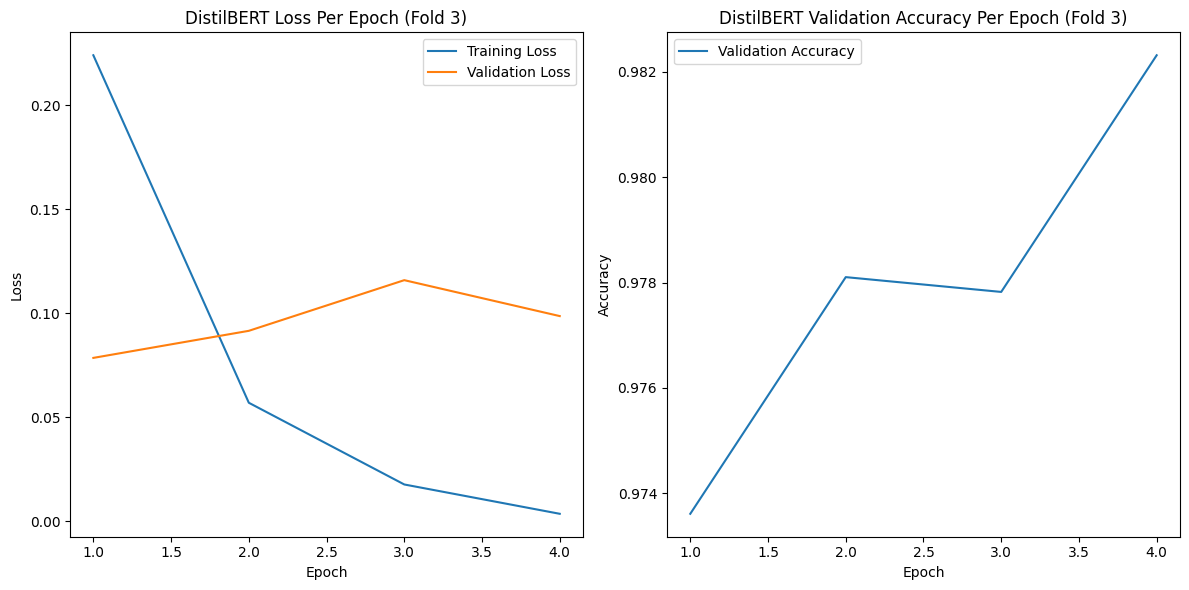

Metrics for Fold 3: {'eval_accuracy': 0.9736103312745649, 'eval_loss': 0.07857093960046768, 'eval_precision': 0.9675500270416442, 'eval_recall': 0.9813494240263302, 'eval_f1': 0.974400871459695, 'eval_runtime': 1.2865, 'eval_samples_per_second': 2768.728, 'eval_steps_per_second': 87.057, 'epoch': 4.0}

Average Metrics Across 3 Folds: {'eval_accuracy': np.float64(0.9778214486243684), 'eval_loss': np.float64(0.08169544364015262), 'eval_precision': np.float64(0.9719191964714572), 'eval_recall': np.float64(0.9851892484914976), 'eval_f1': np.float64(0.9784945272780451), 'eval_runtime': np.float64(1.2848), 'eval_samples_per_second': np.float64(2772.4076666666665), 'eval_steps_per_second': np.float64(87.17266666666667), 'epoch': np.float64(4.0)}


In [3]:
# Cross-validate for DistilBERT
avg_metrics_distilbert = cross_validate(
    model_class=DistilBertForSequenceClassification,
    model_name_or_path='distilbert-base-cased',
    tokenizer=distilbert_tokenizer,
    train_data=train_data_distilbert,
    num_folds=3,
    model_name="DistilBERT"
)


Fold 1/3


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/km/pytorch_env/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.312600,0.122534,0.964437,0.979515,0.949817,0.964437
2,0.104500,0.113529,0.977972,0.967791,0.989545,0.978547
3,0.043500,0.096124,0.983811,0.992030,0.975954,0.983926
4,0.024600,0.096266,0.984076,0.988403,0.980136,0.984252


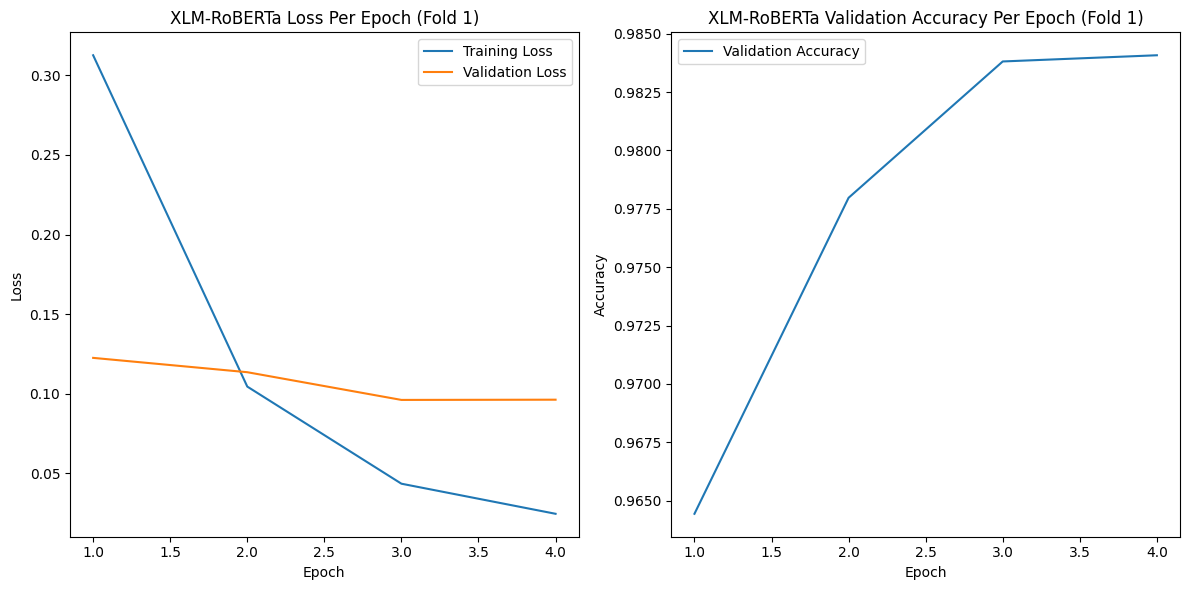

Metrics for Fold 1: {'eval_accuracy': 0.9838110403397028, 'eval_loss': 0.09612387418746948, 'eval_precision': 0.9920297555791711, 'eval_recall': 0.9759539989545217, 'eval_f1': 0.9839262187088273, 'eval_runtime': 2.6947, 'eval_samples_per_second': 1398.281, 'eval_steps_per_second': 43.789, 'epoch': 4.0}

Fold 2/3


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/km/pytorch_env/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.281200,0.117328,0.967879,0.965195,0.971757,0.968465
2,0.100400,0.138305,0.972923,0.985515,0.960774,0.972987
3,0.041200,0.139246,0.975312,0.972468,0.979079,0.975762
4,0.015300,0.156669,0.976905,0.970603,0.984310,0.977408


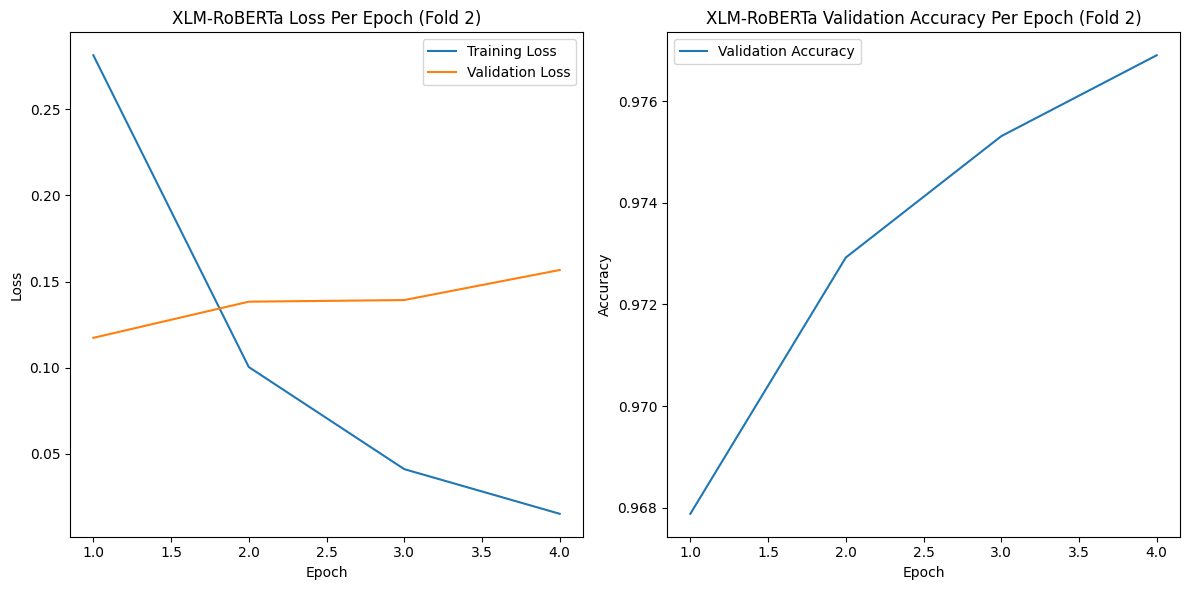

Metrics for Fold 2: {'eval_accuracy': 0.967878948765596, 'eval_loss': 0.11732834577560425, 'eval_precision': 0.9651948051948052, 'eval_recall': 0.9717573221757322, 'eval_f1': 0.9684649465728433, 'eval_runtime': 2.6496, 'eval_samples_per_second': 1421.72, 'eval_steps_per_second': 44.535, 'epoch': 4.0}

Fold 3/3


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/km/pytorch_env/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.299800,0.152797,0.967613,0.967136,0.969158,0.968146
2,0.097900,0.137808,0.967879,0.992849,0.943544,0.967569
3,0.053700,0.112294,0.978763,0.981102,0.976999,0.979047
4,0.020400,0.124640,0.979559,0.978624,0.981181,0.979901


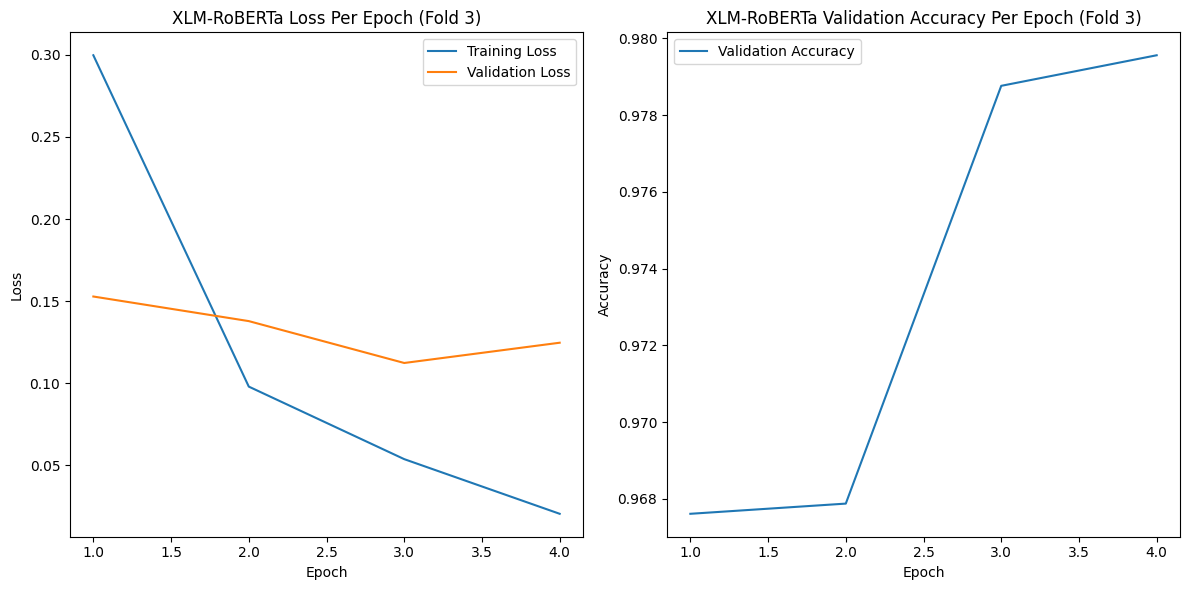

Metrics for Fold 3: {'eval_accuracy': 0.9787629413326254, 'eval_loss': 0.1122935339808464, 'eval_precision': 0.9811023622047244, 'eval_recall': 0.9769994772608468, 'eval_f1': 0.9790466212676794, 'eval_runtime': 2.616, 'eval_samples_per_second': 1439.973, 'eval_steps_per_second': 45.107, 'epoch': 4.0}

Average Metrics Across 3 Folds: {'eval_accuracy': np.float64(0.9768176434793081), 'eval_loss': np.float64(0.10858191798130672), 'eval_precision': np.float64(0.9794423076595669), 'eval_recall': np.float64(0.9749035994637003), 'eval_f1': np.float64(0.9771459288497834), 'eval_runtime': np.float64(2.6534333333333335), 'eval_samples_per_second': np.float64(1419.9913333333334), 'eval_steps_per_second': np.float64(44.477), 'epoch': np.float64(4.0)}


In [4]:
# Cross-validate for XLM-RoBERTa
avg_metrics_xlm = cross_validate(
    model_class=AutoModelForSequenceClassification,
    model_name_or_path='xlm-roberta-base',
    tokenizer=xlm_tokenizer,
    train_data=train_data_xlm,
    num_folds=3,
    model_name="XLM-RoBERTa"
)